<a href="https://colab.research.google.com/github/pmontman/pub-choicemodels/blob/main/nb/solution/solu_tuto_08_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solution to Tutorial 8: Using LIME to explain Machine Learning models




In this tutorial we will connect the 'black box' machine learning models to the 
linear multinomial logit.

Specifically we will use the more interpretable multinomial logit to explain 'parts' of a black box model. The idea is brilliant, and quite recent!.

What we do is:
 * simulate a 'what-if' scenario that is close to a particular observation that we want to explain.
 * Use the 'black box model' as groundth truth, basically the predictions of the model for the what if scenario are taken as the true choices.
 * Fit an explainable linear model to this 'what-if', and then interpret it.

This methodology is called Local interpretable model-agnostic explanations (LIME).

We will use the Swissmetro dataset, fit a ML model (Tutorial 7!) and then explain a particular observation with a multiomial logit.

---
---

# Preparing the environment
*The preparation and dataset loading code is given to the students*

In [1]:
!pip install biogeme

     |████████████████████████████████| 1.5 MB 8.0 MB/s 
     |████████████████████████████████| 235 kB 56.5 MB/s 
  Created wheel for biogeme: filename=biogeme-3.2.8-cp37-cp37m-linux_x86_64.whl size=4030630 sha256=8a37dc213bd7297db6e6ac92bd2f277548112a8623f5bba332cf96034d2ed3f5
  Stored in directory: /root/.cache/pip/wheels/d4/52/61/de6c73d2bc17603c60e754e260bccb7d4da2503e97015ebd49
Successfully built biogeme


Load the packages, feel free to change the names.

In [2]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt

import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.expressions as exp
import biogeme.tools as tools

---
---

# Auxiliary functions

The first function takes the dictionary of utilities, a pandas dataframe, and the name of the variable that contains the variable with the results of the choice. It returns the biogeme object with the model and the estimated 'results' object (the one we get the values, likelihoods, etc.)
We have added the dictionary with the utilities to the biogeme object, in case we use it later.

In [3]:
def qbus_estimate_bgm(V, pd_df, tgtvar_name, modelname='bgmdef'):
 av_auto = V.copy()
 for key, value in av_auto.items():
   av_auto[key] = 1
 bgm_db = db.Database(modelname + '_db', pd_df)
 globals().update(bgm_db.variables)
 logprob = models.loglogit (V , av_auto , bgm_db.variables[tgtvar_name] )
 bgm_model = bio.BIOGEME ( bgm_db, logprob )
 bgm_model.utility_dic = V.copy()
 return bgm_model, bgm_model.estimate()

The next function will calculate the predictions for a given biogeme object that was estimated with `qbus_estimate_bgm`. The output is the array with the choice probabilities. From the choice probabilities, this can be used to calculate accuracies, confusion matrices and the output of what-if scenarios.

In [4]:
def qbus_simulate_bgm(qbus_bgm_model, betas, pred_pd_df):
  av_auto = qbus_bgm_model.utility_dic.copy()
  for key, value in av_auto.items():
   av_auto[key] = 1

  targets = qbus_bgm_model.utility_dic.copy()
  for key, value in targets.items():
   targets[key] = models.logit(qbus_bgm_model.utility_dic, av_auto, key)

  bgm_db = db.Database('simul', pred_pd_df)
  globals().update(bgm_db.variables)
  bgm_pred_model = bio.BIOGEME(bgm_db, targets)
  simulatedValues = bgm_pred_model.simulate(betas)
  return simulatedValues

The function `qbus_calc_accu_confusion` calculates the accuracies given the choice probability predictions a pandas dataset and the specification of the name that contains the actual choices in the input dataset.

In [5]:
def qbus_calc_accu_confusion(sim_probs, pd_df, choice_var):
  which_max = sim_probs.idxmax(axis=1)
  data = {'y_Actual':   pd_df[choice_var],
          'y_Predicted': which_max
        }

  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
  accu = np.mean(which_max == pd_df[choice_var])
  return accu, confusion_matrix 

The next function calculates the likelihood ratio test having to write a bit less code that the default biogeme function. The arguments are the results objects of the two models to be compared. The first is the more complex and the second is the reference model (**the order is important!**). The third argument is the significance level for the test.

In [6]:
def qbus_likeli_ratio_test_bgm(results_complex, results_reference, signif_level):
  return tools.likelihood_ratio_test( (results_complex.data.logLike, results_complex.data.nparam),
                                     (results_reference.data.logLike, results_reference.data.nparam), signif_level)

The next function just updates the globals so we can use it 

In [7]:
def qbus_update_globals_bgm(pd_df):
   globals().update(db.Database('tmp_bg_bgm_for_glob', pd_df).variables)

# Exercise: Try a baseline multinomial logit, decision tree and multilayer perceptron models on the Swismetro dataset and compare the results.

Load the dataset as usual

In [8]:
swissmetro = pd.read_csv('http://transp-or.epfl.ch/data/swissmetro.dat', sep='\t')

Clean the dataset as instructed in Biogeme's example

In [9]:
swissmetro = swissmetro.loc[ swissmetro['CHOICE'] != 0, :]
swissmetro['TRAIN_CO_GA'] = swissmetro['TRAIN_CO'] * (swissmetro['GA'] ==0 )
swissmetro['SM_CO_GA'] = swissmetro['SM_CO'] * (swissmetro['GA'] ==0 )

In [10]:
swissmetro = swissmetro.drop(['TRAIN_AV', 'SM_AV', 'CAR_AV', 'ID'], axis=1)

Fit a base MNL model

In [11]:
qbus_update_globals_bgm(swissmetro)

In [12]:
from sklearn.model_selection import train_test_split
sw_train, sw_test = train_test_split(swissmetro, test_size = 0.25, random_state = 3840)

In [13]:
ASC_CAR = exp.Beta ( 'ASC_CAR' ,0, None , None ,0)
ASC_TRAIN = exp.Beta ( 'ASC_TRAIN' ,0, None , None ,0)
ASC_SM = exp.Beta ( 'ASC_SM' ,0, None , None ,1)
B_TIME = exp.Beta ( 'B_TIME' ,0, None , None ,0)
B_COST = exp.Beta ( 'B_COST' ,0, None , None ,0)
B_MALE_TR = exp.Beta( 'B_MALE_TR', 0, None, None, 0)
B_MALE_SM = exp.Beta( 'B_MALE_SM', 0, None, None, 0)
B_MALE_CAR = exp.Beta( 'B_MALE_CAR', 0, None, None, 0)
B_INCOME_TR = exp.Beta( 'B_INCOME_TR', 0, None, None, 0)
B_INCOME_SM = exp.Beta( 'B_INCOME_SM', 0, None, None, 0)
B_INCOME_CAR = exp.Beta( 'B_INCOME_CAR', 0, None, None, 0)

V1 = ASC_TRAIN + B_TIME * TRAIN_TT + B_COST * TRAIN_CO_GA + B_MALE_TR*MALE + B_INCOME_TR*INCOME
V2 = ASC_SM + B_TIME * SM_TT + B_COST * SM_CO_GA + B_MALE_SM*MALE + B_INCOME_SM*INCOME
V3 = ASC_CAR + B_TIME * CAR_TT + B_COST * CAR_CO + B_MALE_CAR*MALE+ B_INCOME_CAR*INCOME

V_sw = {1: V1, 2:V2, 3:V3}

In [14]:
model_sw, results_sw = qbus_estimate_bgm(V_sw, sw_train, 'CHOICE', 'swismmetro_mnl')

In [15]:
results_sw.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,-1.256416,0.086795,-14.475633,0.000000,0.089056,-14.108160,0.000000
ASC_TRAIN,-0.428556,0.092994,-4.608436,0.000004,0.097510,-4.394984,0.000011
B_COST,-0.004257,0.000328,-12.989321,0.000000,0.000360,-11.837229,0.000000
B_INCOME_CAR,0.052416,0.019507,2.687066,0.007208,0.019964,2.625556,0.008651
B_INCOME_SM,0.024673,0.016702,1.477177,0.139628,0.017415,1.416744,0.156558
B_INCOME_TR,-0.077089,0.022958,-3.357755,0.000786,0.026131,-2.950100,0.003177
B_MALE_CAR,0.711854,0.045574,15.619811,0.000000,0.048760,14.599169,0.000000
B_MALE_SM,0.083666,0.036766,2.275605,0.022870,0.037668,2.221128,0.026342
B_MALE_TR,-0.795520,0.046589,-17.075403,0.000000,0.048016,-16.567714,0.000000
B_TIME,-0.003403,0.000332,-10.246474,0.000000,0.000358,-9.497852,0.000000


Accuracy in the train set

In [16]:
sw_train_sim = qbus_simulate_bgm(model_sw, results_sw.getBetaValues(), sw_train)
qbus_calc_accu_confusion(sw_train_sim, sw_train, 'CHOICE')

(0.5610150516233362, Predicted     2    3
 Actual              
 1          1023   80
 2          4411  215
 3          2211   99)

Accuracy in the test set

In [17]:
sw_test_sim = qbus_simulate_bgm(model_sw, results_sw.getBetaValues(), sw_test)
qbus_calc_accu_confusion(sw_test_sim, sw_test, 'CHOICE')

(0.5809701492537314, Predicted     2   3
 Actual             
 1           290  30
 2          1517  73
 3           730  40)

#Decision tree

In [18]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Instantiate model with 1000 decision trees
#dec_tree = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_features= None)

dec_tree = DecisionTreeClassifier(max_features= None, max_depth=14, random_state=3840 )

In [19]:
dec_tree.fit(sw_train.drop('CHOICE', axis=1), pd.get_dummies(sw_train['CHOICE']));

In [20]:
# Use the predict method on the test data
predictions = dec_tree.predict(sw_test.drop('CHOICE', axis=1))
predictions

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

In [21]:
dec_tree_sim = pd.DataFrame(predictions, columns=[1, 2, 3])

In [22]:
dec_tree_sim.index = sw_test.index

And finally, we can compute the accuracy, we see that is considerably higher thatn the MNL model

In [23]:
qbus_calc_accu_confusion(dec_tree_sim, sw_test, 'CHOICE')

(0.7067164179104478, Predicted    1     2    3
 Actual                   
 1          173   129   18
 2          154  1225  211
 3           40   234  496)

# Neural Network

In [24]:
from sklearn.neural_network import MLPClassifier

neurnet = MLPClassifier(hidden_layer_sizes = (256),
                        activation='logistic',  max_iter=12000, random_state=3840)

In [25]:
neurnet.fit(sw_train.drop('CHOICE', axis=1), pd.get_dummies(sw_train['CHOICE']));

In [26]:
sw_test = sw_train

In [27]:
# Use the predict method on the test data
predictions = neurnet.predict(sw_test.drop('CHOICE', axis=1))
predictions

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 0]])

In [28]:
neurnet_sim = pd.DataFrame(predictions, columns=[1, 2, 3])

In [29]:
neurnet_sim.index = sw_test.index

The accuracy of the neural network is also higher than the MNL (but remember that is is a special case of mixed logit!)

In [30]:
qbus_calc_accu_confusion(neurnet_sim, sw_test, 'CHOICE')

(0.7706182360990173, Predicted    1     2     3
 Actual                    
 1          788   275    40
 2          508  3638   480
 3          198   343  1769)

# LIME

The methodology of LIME, in a nutshell

1. Select your observation of interest for which you want to have an explanation of its black box prediction.
2. Perturb the observation to create a new dataset and get the black box predictions for these new points.
3. Train  interpretable model on the dataset with the variations.
4. Explain the prediction of the original by interpreting the local model.

*Material from [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/lime.html)*(Christoph Molnar).

We start by picking the observation we want to explain from the test test

In [31]:
observ = sw_test.iloc[[0,]]
observ

,GROUP,SURVEY,SP,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,MALE,INCOME,GA,ORIGIN,DEST,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE,TRAIN_CO_GA,SM_CO_GA
8273,3,1,1,3,1,3,2,1,4,1,3,0,22,17,300,202,30,143,274,20,0,312,140,2,202,274


The prediction of the black box model, it predicts 2=Swissmetro

In [32]:
dec_tree.predict( observ.drop('CHOICE', axis=1))

array([[0, 1, 0]], dtype=uint8)

# Create the what-if scenario around the desired observation
Create a 'new dataset' by creating synthetic observations that are 'close' to the observation we want to explain, but not exactly the same. We will do this by
adding Gaussian noise to the measurements of the observation.
We will scale the noise by the standard deviation of each variable.

In [33]:
stdcols = sw_train.std(axis=0)
stdcols

GROUP             0.481452
SURVEY            0.481452
SP                0.000000
PURPOSE           1.158699
FIRST             0.499305
TICKET            2.199147
WHO               0.709973
LUGGAGE           0.605438
AGE               1.030948
MALE              0.432337
INCOME            0.942083
GA                0.347465
ORIGIN           10.156168
DEST              9.735157
TRAIN_TT         76.908112
TRAIN_CO       1080.259882
TRAIN_HE         37.463203
SM_TT            52.761652
SM_CO          1437.426119
SM_HE             8.148195
SM_SEATS          0.323128
CAR_TT           86.710388
CAR_CO           55.099929
CHOICE            0.634084
TRAIN_CO_GA      68.550145
SM_CO_GA         84.500802
dtype: float64

The declare the 'area' around the observation, how much we

In [34]:
NEIGHBOURHOOD = 0.3

We replicate the observation to create a new datase, and the we will add Gaussian noise to it.

In [35]:

neighb_observ = pd.DataFrame(np.repeat(observ.values, 1000, axis=0))
neighb_observ.columns = observ.columns

neighb_observ

,GROUP,SURVEY,SP,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,MALE,INCOME,GA,ORIGIN,DEST,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE,TRAIN_CO_GA,SM_CO_GA
0,3,1,1,3,1,3,2,1,4,1,3,0,22,17,300,202,30,143,274,20,0,312,140,2,202,274
1,3,1,1,3,1,3,2,1,4,1,3,0,22,17,300,202,30,143,274,20,0,312,140,2,202,274
2,3,1,1,3,1,3,2,1,4,1,3,0,22,17,300,202,30,143,274,20,0,312,140,2,202,274
3,3,1,1,3,1,3,2,1,4,1,3,0,22,17,300,202,30,143,274,20,0,312,140,2,202,274
4,3,1,1,3,1,3,2,1,4,1,3,0,22,17,300,202,30,143,274,20,0,312,140,2,202,274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,1,1,3,1,3,2,1,4,1,3,0,22,17,300,202,30,143,274,20,0,312,140,2,202,274
996,3,1,1,3,1,3,2,1,4,1,3,0,22,17,300,202,30,143,274,20,0,312,140,2,202,274
997,3,1,1,3,1,3,2,1,4,1,3,0,22,17,300,202,30,143,274,20,0,312,140,2,202,274
998,3,1,1,3,1,3,2,1,4,1,3,0,22,17,300,202,30,143,274,20,0,312,140,2,202,274


In [36]:
import random


for i, row in neighb_observ.iterrows():
    #print(i)
    #observ2.at[i,'ifor'] = 2
    for column in neighb_observ.iloc[[i,]]:
     #print(column)
     neighb_observ.at[i, column] += random.gauss(0,stdcols[column]*NEIGHBOURHOOD)
     #print(random.gauss(0,stdcols[column]*NEIGHBOURHOOD))
     #print(observ2.at[i, column])

Once we have the synthetics dataset, we calculate the predictions of the black box models and take then as the ground truth, we overwrite the 'CHOICE' variable.

In [37]:
neighb_observ

,GROUP,SURVEY,SP,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,MALE,INCOME,GA,ORIGIN,DEST,TRAIN_TT,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE,TRAIN_CO_GA,SM_CO_GA
0,3,1,1,2,0,2,2,0,4,0,3,0,19,13,319,138,36,144,689,17,0,298,147,2,214,269
1,2,1,1,3,1,2,1,1,4,0,2,0,26,20,332,574,29,144,217,22,0,277,147,2,168,268
2,3,1,1,3,0,2,1,0,4,1,2,0,24,11,324,678,41,142,165,20,0,367,131,1,188,331
3,2,1,1,2,1,3,2,0,4,1,3,0,22,18,282,533,33,148,211,25,0,302,115,2,213,257
4,2,0,1,3,0,2,2,1,4,0,2,0,20,17,320,353,26,122,1442,23,0,339,129,1,173,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,1,1,3,0,2,2,1,3,1,3,0,22,20,343,398,35,111,369,19,0,253,127,2,214,287
996,3,0,1,2,0,3,2,1,4,1,3,0,18,14,278,-298,31,159,90,23,0,313,147,1,204,294
997,3,1,1,2,0,3,1,0,3,1,3,0,20,15,287,675,33,138,369,21,0,307,133,2,198,281
998,2,0,1,3,0,3,1,0,3,0,3,0,20,19,305,232,18,138,130,22,0,315,149,2,184,283


In [38]:
neighb_preds = dec_tree.predict( neighb_observ.drop('CHOICE', axis=1))


In [39]:
neighb_preds

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0]], dtype=uint8)

In [40]:
neighb_choices = pd.DataFrame(neighb_preds).idxmax(axis=1) + 1
neighb_observ['CHOICE'] = neighb_choices

In [41]:
neighb_choices

0      1
1      2
2      3
3      2
4      2
      ..
995    2
996    2
997    1
998    1
999    2
Length: 1000, dtype: int64

Estimate a basic multinomial logit to the dataset.

In [42]:
model_lime, results_lime = qbus_estimate_bgm(V_sw, neighb_observ, 'CHOICE', 'lime_mnl')

We are done, it just remains interpreting the results.

In [43]:
results_lime.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,-0.826735,0.626387,-1.319847,1.868860e-01,0.605821,-1.364652,1.723624e-01
ASC_TRAIN,-3.629239,0.719629,-5.043212,4.577824e-07,0.740187,-4.903141,9.431644e-07
B_COST,-0.006812,0.002133,-3.194154,1.402411e-03,0.002165,-3.145778,1.656457e-03
B_INCOME_CAR,-0.497331,0.120631,-4.122750,3.743763e-05,0.120065,-4.142177,3.440252e-05
B_INCOME_SM,0.024329,0.099707,0.244007,8.072253e-01,0.100219,0.242761,8.081908e-01
B_INCOME_TR,0.473002,0.152571,3.100206,1.933859e-03,0.153168,3.088118,2.014281e-03
B_MALE_CAR,0.031845,0.118410,0.268940,7.879756e-01,0.118469,0.268806,7.880789e-01
B_MALE_SM,0.065906,0.097588,0.675354,4.994509e-01,0.097713,0.674487,5.000018e-01
B_MALE_TR,-0.097751,0.149147,-0.655401,5.122095e-01,0.150030,-0.651547,5.146936e-01
B_TIME,0.000217,0.002174,0.099862,9.204535e-01,0.002114,0.102665,9.182286e-01


Maybe recovering the choice probabilities.

In [44]:
observ_sim = qbus_simulate_bgm(model_lime, results_lime.getBetaValues(), observ)
observ_sim

,1,2,3
8273,0.106394,0.727403,0.166203


---
---

#Exercise: Comment on the effect of altering the neighbourhood area

*The idea here is to set a few values for the neighbourhood area and compare the results of the estimation. We will do something a bit more sophisticated just for illustration purposes.*

**What we need to know from the exercise the overall pattern: as we increase the area around the chosen point, the interpretable model degrades. In general a simple model cannot explain the whole dataset well, and the larger the area, the more the neighbourhood resembles the whole dataset. How to choose the proper area size and how to specify the interpretable model is, unfortunately, a non-solved issue, so it is still trial-and-error and subjective. **

We will loop through a range of values for the neighbourhood area and recover values of goodness of fit and the two main coefficients of the model, cost and travel time for each of the areas. That way we can get a clear picture of the overall relationship with area size and model.

We choose the point to explain, you can change this to another value and rerun the cells below (the results will be qualitatively similar for most points).

In [52]:
observ = sw_test.iloc[[15,]]

The range of values will be between 0.0001 (a very small value) and 3. We choose 3 because the area is scaled by the standard deviation of each variable, and 3 times the standard deviation covers most of the sampled area!.

In [53]:
NB_range = np.linspace(0.0001, 3, 100)

The next cell is copied from the tutorial, just inside a for loop to try different neighbourhood values, and save the results for the loglikelihoods and coefficients.

**Warning: It takes about 5 minutes to run!**

In [54]:
logliks = []
costs = []
times = []

for NEIGHBOURHOOD in NB_range:
 neighb_observ = pd.DataFrame(np.repeat(observ.values, 2000, axis=0))
 neighb_observ.columns = observ.columns

 for i, row in neighb_observ.iterrows():
    #print(i)
    #observ2.at[i,'ifor'] = 2
    for column in neighb_observ.iloc[[i,]]:
     #print(column)
     neighb_observ.at[i, column] += random.gauss(0,stdcols[column]*NEIGHBOURHOOD)
     #print(random.gauss(0,stdcols[column]*NEIGHBOURHOOD))
     #print(observ2.at[i, column])
 neighb_preds = dec_tree.predict( neighb_observ.drop('CHOICE', axis=1))
 neighb_choices = pd.DataFrame(neighb_preds).idxmax(axis=1) + 1
 neighb_observ['CHOICE'] = neighb_choices
 model_lime, results_lime = qbus_estimate_bgm(V_sw, neighb_observ, 'CHOICE', 'lime_mnl')
 logliks.append(results_lime.data.logLike)
 costs.append(results_lime.getBetaValues()['B_COST'])
 times.append(results_lime.getBetaValues()['B_TIME'])
 

We plot the loglikelihoods as a crude approximation of how good a model is, depending on the area of the neighbourhood. For this datapoint, roughly speaking, a neighbourhood around 0.75 provides a relatively good likelihood. so it seems a good 'sweet spot' for the area.

 Note that this is not a rigorous interpretation, we cannot easily compare the likelihoods on different datasets.

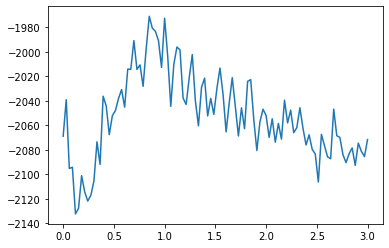

In [55]:
plt.plot(NB_range, logliks)

We plot the values of the `B_COST` parameter and we see a similar picture:
we know that the cost should have negative values, the more negative ones are attained at an area of 0.25.


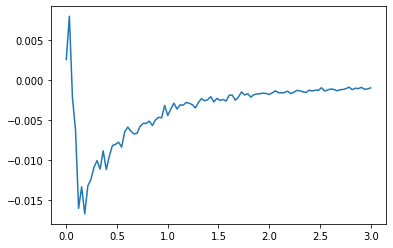

In [56]:
plt.plot(NB_range, costs)

For the `B_TIME` paramter the results are qualitatively similar, it gets a minimum around 0.5 and then goes to 0.

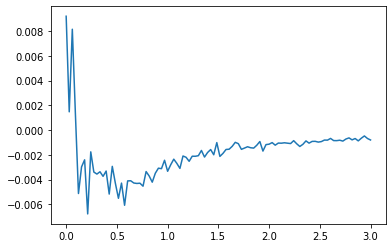

In [57]:
plt.plot(NB_range, times)

Summarizing, what we observe is that small areas around the point produce 'degenerate results' (maybe because there is not much information) and then we hit a sweet spot for the area value where the models seem reasonable. Then, what we see is that the larger the area, the worse the model becomes in both expected values for the parameters and goodness of fit.



----
----

# Extra: Variable importance to help find a good intepretable model

Specifying the simple model to explain the complex one is not trivial. Most of the time it should be based on what we consider 'interpretable' (which variables go in, usually linear with few transformations and interactions). The difficulty is finding a model that is interpretable and covers an area 'large enough' so we do not have to consider thousands of explanatory models to cover the whole dataset (and beyond).

However, some of the more complex models, such as decision tress, are 'somewhat interpretable' already. For example, decision trees can compute a measure of the importance of each variable. We can use this as a guideline for our intepretable model, Which variables are important for the tree? Maybe they help in the linear model...

Clarification: This is something we can do, it does not mean that it is going to be always useful, there is no guarantee that what is good variable for a decision tree also works for a linear model.  In particular, we use LIME precisely because we do not understand how the complex model works, it can be used to explain any model. If we are already satisified by what we know about the complex model, we would not need LIME.

In the next cell we see the importance of the variables in the decision tree model, we see that most of the top variables are already being considered in the linear model. 

In [58]:
feat_import = pd.DataFrame(dec_tree.feature_importances_.T, columns=['importance'])
feat_import['varname'] = sw_train.drop('CHOICE', axis=1).columns
feat_import.sort_values(by='importance', ascending=False)

,importance,varname
21,0.111955,CAR_TT
17,0.106408,SM_TT
1,0.099773,SURVEY
14,0.086138,TRAIN_TT
22,0.075543,CAR_CO
15,0.061793,TRAIN_CO
8,0.059089,AGE
18,0.058682,SM_CO
24,0.049508,SM_CO_GA
13,0.040923,DEST
